In [1]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

import os
import random
import shutil
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight

normal_paths = glob.glob('chest_xray/*/NORMAL/*.jpeg')
pneumonia_paths = glob.glob('chest_xray/*/PNEUMONIA/*.jpeg')

normal_labels = [(p, 0) for p in normal_paths]
pneumonia_labels = [(p, 1) for p in pneumonia_paths]
all_data = normal_labels + pneumonia_labels
df = pd.DataFrame(all_data, columns=['path', 'label'])

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_idx, temp_idx in sss1.split(df['path'], df['label']):
  train_data = df.iloc[train_idx]
  temp_data = df.iloc[temp_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_idx, test_idx in sss2.split(temp_data['path'], temp_data['label']):
  val_data = temp_data.iloc[val_idx]
  test_data = temp_data.iloc[test_idx]

for folder in ['DATA/train/NORMAL','DATA/train/PNEUMONIA',
               'DATA/val/NORMAL','DATA/val/PNEUMONIA',
               'DATA/test/NORMAL','DATA/test/PNEUMONIA']:
  os.makedirs(folder, exist_ok=True)

def copy_files(dataframe, subset):
  for i in range(len(dataframe)):
    src = dataframe.iloc[i]['path']
    lbl = dataframe.iloc[i]['label']
    if lbl == 0:
      dst = f"DATA/{subset}/NORMAL/{os.path.basename(src)}"
    else:
      dst = f"DATA/{subset}/PNEUMONIA/{os.path.basename(src)}"
    shutil.copy2(src, dst)

copy_files(train_data, 'train')
copy_files(val_data, 'val')
copy_files(test_data, 'test')

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:18<00:00, 195MB/s]
100% 2.29G/2.29G [00:18<00:00, 136MB/s]


In [2]:

device_name = tf.test.gpu_device_name()
if '/device:GPU:0' not in device_name:
    raise SystemError('GPU device not found. \n'
                      'Change runtime to GPU in Colab from the menu.')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


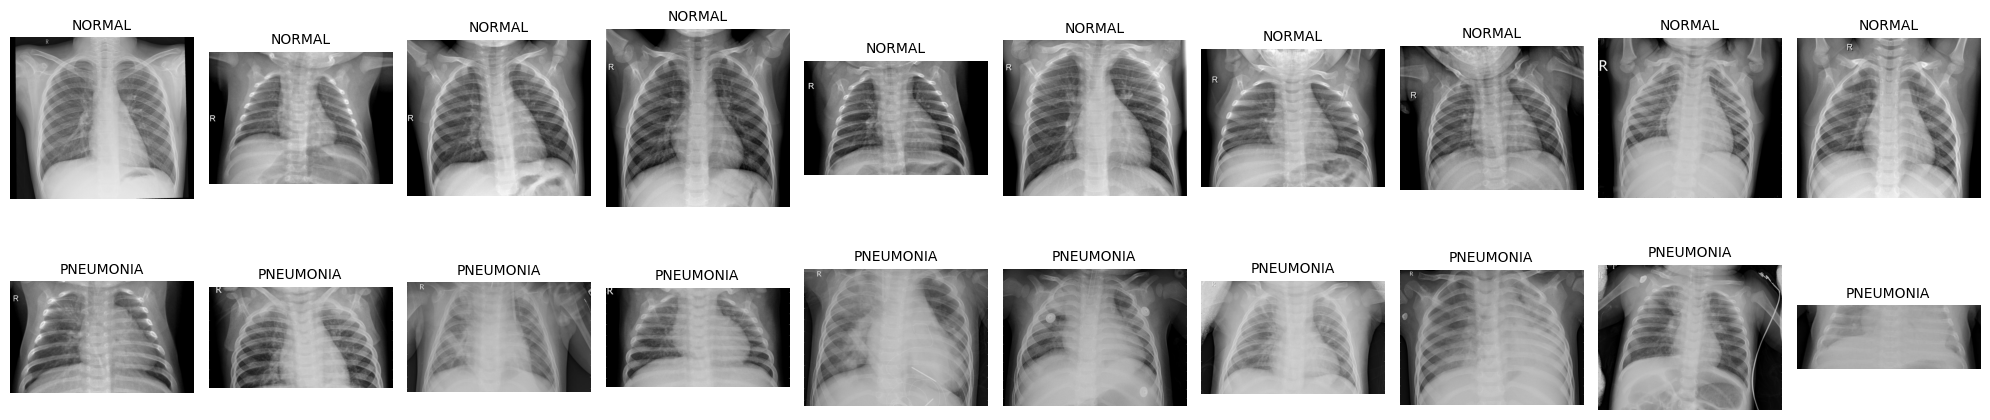

In [3]:


normal_sample = random.sample(glob.glob('DATA/train/NORMAL/*.jpeg'), 10)
pneumonia_sample = random.sample(glob.glob('DATA/train/PNEUMONIA/*.jpeg'), 10)

fig, axes = plt.subplots(2, 10, figsize=(20, 5))

for i, img_path in enumerate(normal_sample):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title("NORMAL", fontsize=10)

for i, img_path in enumerate(pneumonia_sample):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title("PNEUMONIA", fontsize=10)

plt.tight_layout()
plt.show()


Explanation of Network Architecture Layers

Base Network (EfficientNet Backbone)

The core of the model is built upon a pre-trained EfficientNet (specifically EfficientNetB2 in this exercise).
EfficientNet employs a series of Mobile Inverted Bottleneck Convolution (MBConv) blocks along with Squeeze-and-Excitation mechanisms.
The MBConv block uses depthwise separable convolutions, which greatly reduce the number of parameters and floating-point operations (FLOPs) required.
Squeeze-and-Excitation involves learning per-channel weights (or “importance”) and helps the network focus on the most informative feature channels.
Freezing Initial Layers

In transfer learning, we often freeze the initial layers of the EfficientNet to retain the generic low-level features (edges, textures, etc.) these layers have already learned from ImageNet.
By freezing layers, the weights in those layers will not be updated during training, reducing overfitting when our dataset is small.
Global Average Pooling

After the EfficientNet feature extraction, a Global Average Pooling (GAP) layer is typically used to reduce each feature map into a single number by averaging across spatial dimensions.
This approach replaces dense layers with many parameters; thus it helps reduce overfitting and overall parameter count.
Fully Connected (Dense) Layers

Post-pooling, the feature vector is passed through one or more Dense layers with an activation function (such as ReLU).
These layers perform high-level reasoning about the features extracted by EfficientNet.
Dropout Layers

Dropout is added to reduce overfitting by randomly setting a fraction of the layer outputs to zero during training.
This encourages the network to learn robust features that do not rely on any one particular neuron’s output.
Final Classification Layer

The last Dense layer has a single unit (because we have two classes: normal vs. pneumonia) with a sigmoid activation function.
Outputs a probability in the range [0, 1] indicating whether the input image is normal or pneumonia.




Why EfficientNet was Chosen

High Accuracy with Fewer Parameters: EfficientNet scales depth, width, and resolution of the network in a balanced way (compound scaling), which typically yields better accuracy than other architectures while using fewer parameters.
Computational Efficiency: Due to its use of MBConv blocks and careful scaling, EfficientNet significantly reduces computational cost (FLOPs).
Strong Pretraining: EfficientNet is pre-trained on ImageNet, providing robust initial feature extraction capabilities. This is especially valuable for medical imaging tasks where datasets can be relatively small, as is the case with pneumonia detection.
Proven Performance: In various benchmarks, EfficientNet models show state-of-the-art or near-state-of-the-art results, making them an excellent choice for transfer learning in image classification tasks.

Found 3513 images belonging to 2 classes.
Found 1171 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Class Weights: {0: 1.8489473684210527, 1: 0.6853296917674601}


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, 128, 128, 3)    │              7 │ rescaling_6[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_7[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 7,957,242 (30.35 MB)

 Trainable params: 7,859,255 (29.98 MB)

 Non-trainable params: 97,987 (382.77 KB)

Epoch 1: Learning rate set to 0.001000

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.6977 - loss: 0.5506
Epoch 1: val_loss improved from inf to 0.71860, saving model to best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6981 - loss: 0.5501 - val_accuracy: 0.2331 - val_loss: 0.7186 - learning_rate: 0.0010
Epoch 2: Learning rate set to 0.000900

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8197 - loss: 0.3838
Epoch 2: val_loss did not improve from 0.71860
110/110 ━━━━━━━━━━━━━━━━━━━━ 101s 458ms/step - accuracy: 0.8197 - loss: 0.3838 - val_accuracy: 0.7301 - val_loss: 1.0519 - learning_rate: 9.0000e-04
Epoch 3: Learning rate set to 0.000810

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8452 - loss: 0.3366
Epoch 3: val_loss did not improve from 0.71860
110/110 ━━━━━━━━━━━━━━━━━━━━ 82s 463ms/step

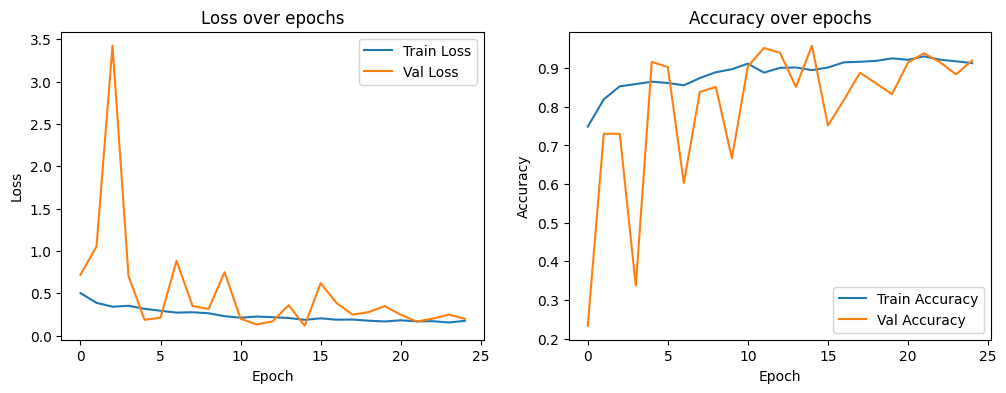

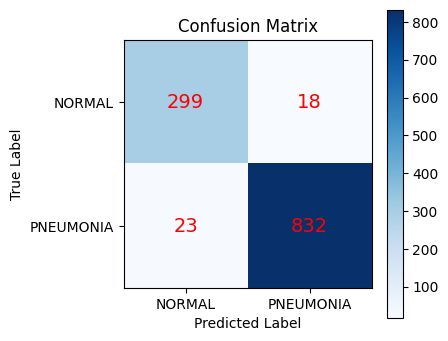

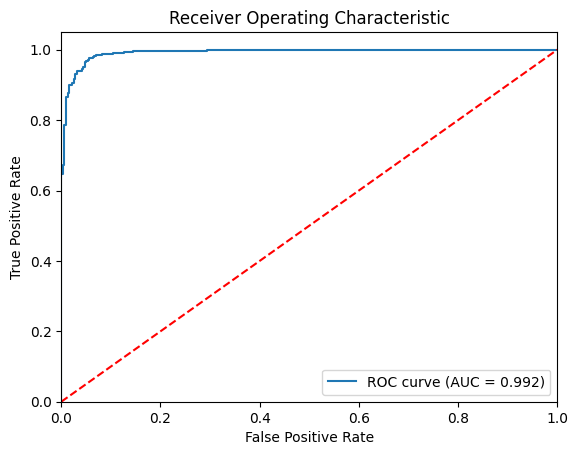

In [7]:


###########################################
# 1) تقسیم داده‌ها + Data Augmentation
###########################################


train_dir = 'DATA/train'
val_dir   = 'DATA/val'
test_dir  = 'DATA/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

train_labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

###########################################
# 2) ساخت مدل EfficientNetB2
###########################################
base_model = EfficientNetB2(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)

# فریز کردن اولین 74 لایه
for i, layer in enumerate(base_model.layers[:74]):
    layer.trainable = False

# طراحی بخش بالایی شبکه (Classifier Head)
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)   # Dropout = 0.3 مطابق مقاله
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)   # Dropout = 0.2 مطابق مقاله
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=output)

###########################################
# 3) تعریف تابع کاهش نرخ یادگیری (LearningRateScheduler)
###########################################
def lr_scheduler_exponential(epoch, current_lr):

    initial_lr = 0.001
    gamma = 0.9

    new_lr = initial_lr * (gamma ** epoch)

    print(f"Epoch {epoch+1}: Learning rate set to {new_lr:.6f}")
    return new_lr


###########################################
# 4) کامپایل مدل
###########################################
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),  # مقدار اولیه: 0.001
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

###########################################
# 5) تعریف Callbacks (EarlyStopping, ModelCheckpoint, LearningRateScheduler)
###########################################
early_stopping = EarlyStopping(
    monitor='val_loss',   # طبق مقاله
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

lr_callback_exp = LearningRateScheduler(lr_scheduler_exponential, verbose=1)

###########################################
# 6) آموزش مدل
###########################################
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30,
        callbacks=[early_stopping, model_checkpoint, lr_callback_exp],
        class_weight=class_weights_dict
    )

###########################################
# 7) ارزیابی روی داده تست
###########################################
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
y_pred_proba = model.predict(test_gen, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int)
y_true = test_gen.classes

precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
acc       = accuracy_score(y_true, y_pred)

print("Test Accuracy: ", acc)
print("Precision    : ", precision)
print("Recall       : ", recall)
print("F1-score     : ", f1)

###########################################
# 8) نمایش نمودار Loss و Accuracy
###########################################
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

###########################################
# 9) رسم Confusion Matrix
###########################################
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0,1], ['NORMAL','PNEUMONIA'])
plt.yticks([0,1], ['NORMAL','PNEUMONIA'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha='center', va='center',
                 color='red', fontsize=14)
plt.show()

###########################################
# 10) رسم ROC Curve
###########################################
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %.3f)' % roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



Notes on Chosen/Specified Hyperparameters:

Learning Rate: 0.001 (as mentioned in the article).
Optimizer: Adam.
Loss Function: Binary Crossentropy (for two-class classification).
Batch Size: 32 (specified in the instructions).
Epochs: 30 (as stated in the article).
Dropout Rates: 30% and 20% in the two intermediate Dense layers (from the article).
This configuration follows the architecture described in the article, including the freezing of the first 74 layers of the EfficientNetB2 base and adding the custom top layers for final classification.